In [2]:

import pandas as pd
import numpy as np
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, TiDEModel
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss,MAE, RMSE, MAPE, SMAPE
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pytorch_forecasting.models import TimeXer
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.callbacks import EarlyStopping,ModelCheckpoint
from lightning.pytorch.callbacks import Callback
from pytorch_forecasting.models import TimeXer
import matplotlib.collections as mcoll 
from matplotlib.gridspec import GridSpec
from pytorch_forecasting.models.nhits import NHiTS




In [3]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
df = pd.read_csv("data/timexer.csv", parse_dates=["date"])
df = df.sort_values("date")
df["time_idx"] = (df["date"] - df["date"].min()).dt.total_seconds().astype(int)
df["series_id"] = 0

In [5]:
df.head()

,date,bytes_op0,bytes_op1,bytes_sum,io_count,read_ops_count,write_ops_count,bytes_sum_ema_short,bytes_sum_ema_long,bytes_sum_macd,bytes_sum_macd_signal,duration_sum,time_idx,series_id
0,2024-12-05 13:07:35,20982.0,10491.0,31473.0,5.0,4.0,1.0,31473.000000,31473.000000,0.000000,0.000000,0.000310,0,0
1,2024-12-05 13:07:36,31473.0,31473.0,62946.0,9.0,6.0,3.0,37195.363636,32504.901639,4690.461997,446.710666,0.000575,1,0
2,2024-12-05 13:07:37,31473.0,31473.0,62946.0,9.0,6.0,3.0,41877.297521,33502.970438,8374.327083,1201.721754,0.000587,2,0
3,2024-12-05 13:07:38,31473.0,41964.0,73437.0,10.0,6.0,4.0,47615.425244,34812.282883,12803.142361,2306.618954,0.000600,3,0
4,2024-12-05 13:07:39,31473.0,20982.0,52455.0,8.0,6.0,2.0,48495.347927,35390.732624,13104.615303,3334.999559,0.000483,4,0


In [6]:
num_train = int(len(df) * 0.7)
num_test  = int(len(df) * 0.2)
num_vali  = len(df) - num_train - num_test

In [7]:
train_df = df.iloc[:num_train]
val_df   = df.iloc[num_train : num_train + num_vali]
test_df  = df.iloc[num_train + num_vali :]


In [8]:
max_encoder_length = 50
max_prediction_length = 1
static_categoricals = []
static_reals = []
time_varying_known_reals = [
    "bytes_op0","bytes_op1","bytes_sum","io_count",
    "read_ops_count","write_ops_count",
    "bytes_sum_ema_short","bytes_sum_ema_long",
    "bytes_sum_macd","bytes_sum_macd_signal",
]
time_varying_unknown_reals = ["duration_sum"]
group_ids = ["series_id"]
target = "duration_sum"
batch_size = 64
epochs = 50



In [9]:
covariate_scalers = {
    var: GroupNormalizer(groups=["series_id"]) 
    for var in time_varying_known_reals
}

In [10]:
model_kwargs = dict(
    learning_rate=1e-3,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=128,
    loss=QuantileLoss(quantiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 0.99,0.999]),  
    output_size=11,              # default: QuantileLoss
    logging_metrics=[SMAPE(),MAE(), RMSE(), MAPE()],
    log_interval=10,
    reduce_on_plateau_patience=4,
)


In [11]:
trainer_kwargs = dict(
    max_epochs=epochs,
    accelerator="gpu",
    devices=1,
    gradient_clip_val=0.1,
)

In [12]:
# Horizons to run
horizon = 25

In [13]:
training = TimeSeriesDataSet(
        train_df, time_idx="time_idx", group_ids=group_ids, target=target,
        max_encoder_length=max_encoder_length, max_prediction_length=horizon,
        static_categoricals=static_categoricals, static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=group_ids),
       scalers=covariate_scalers,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
    )
validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=False)

    # Dataloaders
train_loader = training.to_dataloader(train=True,  batch_size=batch_size, num_workers=0)
val_loader   = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=False)
test_loader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [14]:
# model_20 = TemporalFusionTransformer.load_from_checkpoint("ckpts/horizon_20/best-epoch=02-val_loss=0.0006.ckpt")
model_20 = TemporalFusionTransformer.load_from_checkpoint("all_for_plot/run_1/horizon_25/best-epoch=02-val_loss=0.0006.ckpt")
raw_outputs = model_20.predict(
    test_loader,
    mode="raw",           # full model outputs, including the `prediction` tensor
    return_x=False,       # we only want the model outputs
    return_y=False,
    batch_size=batch_size,
    num_workers=0
)

# 2. Extract the prediction tensor: shape = (n_windows, prediction_length, n_quantiles)
#    In PyTorch Forecasting v0.10+, raw_outputs is an AttributeDict, so:
pred_tensor = raw_outputs["prediction"]  
# it’s a torch.Tensor; move to CPU/NumPy:
preds = pred_tensor.detach().cpu().numpy()  
# Now `preds.shape == (n_windows, horizon, n_quantiles)`

# 3. Gather the true values in the same sliding-window order:
#    This is the concatenation of the decoder’s true targets that your dataset would produce.
actuals = np.concatenate([
    y.detach().cpu().numpy()
    for _, (y, _) in iter(test_loader)
], axis=0)
# actuals.shape == (n_windows, horizon)

# 4. Compute MSE for each quantile over **all** time-steps & windows:
quantile_levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 0.99,0.999]  # e.g. [0.1, 0.5, 0.9]
for q_idx, q in enumerate(quantile_levels):
    # flatten windows × time-steps into one long vector
    q_preds = preds[:, :, q_idx].reshape(-1)
    y_true = actuals.reshape(-1)
    mse_q = mean_squared_error(y_true, q_preds)
    print(f"Quantile {q:>4.2f} — MSE = {mse_q:.6f}")

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('N

Quantile 0.10 — MSE = 0.000037
Quantile 0.20 — MSE = 0.000034
Quantile 0.30 — MSE = 0.000033
Quantile 0.40 — MSE = 0.000033
Quantile 0.50 — MSE = 0.000032
Quantile 0.60 — MSE = 0.000032
Quantile 0.70 — MSE = 0.000032
Quantile 0.80 — MSE = 0.000032
Quantile 0.90 — MSE = 0.000033
Quantile 0.99 — MSE = 0.000036
Quantile 1.00 — MSE = 0.000146


In [15]:
raw_predictions = model_20.predict(
    test_loader,
    mode="raw",
    return_x=True,
 
)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


In [16]:
timexer = TimeXer.load_from_checkpoint("checkpoints_timexer_norm_multirun_lon/run_1/horizon_25/best-epoch=05-val_loss=0.0000.ckpt")
tx_raw  = timexer.predict(
    test_loader
)
tide = TiDEModel.load_from_checkpoint("checkpoints_tide_multirun_lon/run_1/horizon_25/best-epoch=09-val_loss=0.0000.ckpt")
tide_raw = tide.predict(
    test_loader
)

print(tx_raw.shape,tide_raw.shape)


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

torch.Size([39741, 25]) torch.Size([39741, 25])


In [17]:
idx = 820
# tx_raw = tx_raw.detach().cpu().numpy()

tx_seq       = tx_raw[idx].detach().cpu().numpy()
tide_seq = tide_raw[idx].detach().cpu().numpy()
horizon = tx_seq.shape[0]
hist_ts  = np.arange(-50, 0)
fut_ts   = np.arange(0, horizon)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


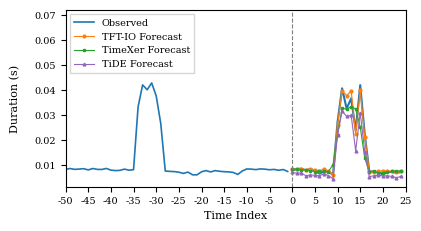

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.collections as mcoll

idx = 820

# ---- SAME publication-style settings as your other figures ----
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "axes.linewidth": 0.8,
    "ps.fonttype": 42,
    "pdf.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(5, 2.3))

# 1) Draw TFT’s full observed (history + future) and its own forecast
model_20.plot_prediction(
    raw_predictions.x,
    raw_predictions.output,
    idx=idx,
    plot_attention=False,
    ax=ax
)

# Remove legend added by plot_prediction
if ax.get_legend() is not None:
    ax.get_legend().remove()
for lg in list(fig.legends):
    lg.remove()
fig.legends.clear()

# 2) Remove quantile shaded bands
for coll in list(ax.collections):
    if isinstance(coll, mcoll.PolyCollection):
        coll.remove()

# 3) Recolor “Observed” (robust: handle cases where label isn't exactly "Observed")
for ln in ax.get_lines():
    if "observed" in ln.get_label().lower():
        ln.set_color("#1f77b4")
        ln.set_linewidth(1.2)
        ln.set_label("Observed")

# 4) Recolor TFT forecast
tft_line = next(l for l in ax.get_lines() if "predicted" in l.get_label().lower())
tft_line.set_color("#ff7f0f")
tft_line.set_marker("o")
tft_line.set_markersize(2)

tft_line.set_linewidth(0.8)
tft_line.set_label("TFT-IO Forecast")

# 5) Determine forecast horizon
horizon = len(tft_line.get_xdata())
fut_ts = np.arange(0, horizon)

# 6) Overlay TimeXer and TiDE (use hex colors for consistency)
ax.plot(
    fut_ts, tx_seq,
    color="#2ca02c", label="TimeXer Forecast",
    marker="s",
    markersize=2,
    linewidth=0.8
)
ax.plot(
    fut_ts, tide_seq,
    color="#9467bd", label="TiDE Forecast",
    marker="^",
    markersize=2,
    linewidth=0.8
)

# 7) Build legend (match your style: simple, no fancy box)
observed = next(l for l in ax.get_lines() if l.get_label() == "Observed")
tft_fc   = next(l for l in ax.get_lines() if l.get_label() == "TFT-IO Forecast")
tx_fc    = next(l for l in ax.get_lines() if l.get_label() == "TimeXer Forecast")
tide_fc  = next(l for l in ax.get_lines() if l.get_label() == "TiDE Forecast")

ax.legend(
    [observed, tft_fc, tx_fc, tide_fc],
    ["Observed", "TFT-IO Forecast", "TimeXer Forecast", "TiDE Forecast"],
    loc="upper left",
    frameon=True,
    fancybox=False,
    fontsize=7
)

# 8) Tighten x-axis and ticks (keep your intent)
all_x = np.hstack([l.get_xdata() for l in [observed, tft_fc, tx_fc, tide_fc]])
ax.set_xlim(all_x.min(), all_x.max())
ax.margins(x=0)

xticks = np.arange(-50, 26, 5)
ax.set_xticks(xticks)
ax.set_xticklabels([str(int(t)) for t in xticks])

# 9) Labels + styling (same format as other plots)
ax.set_xlabel("Time Index")
ax.set_ylabel("Duration (s)", labelpad=10)

# EPS-friendly: avoid alpha
ax.axvline(0, color="gray", linestyle="--", linewidth=0.8)

# Subtle grid like your other figures
# ax.grid(True, axis="y", linewidth=0.4, alpha=0.4)
ax.set_axisbelow(True)

# Prevent label clipping (same fix you use)
fig.subplots_adjust(left=0.22)

# Save EPS (pad_inches helps avoid clipping)
fig.savefig("plots/horizon_25_acm.eps",
            format="eps", bbox_inches="tight", pad_inches=0.08)

plt.show()


In [96]:
import glob
# Your quantile levels and horizons
quantile_levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,0.999]
horizons = [ 5, 10, 15, 20,25]  # adjust as needed
batch_size = 64 
results = []               # whatever you used

for h in horizons:
    ckpt_dir = f"all_for_plot/run_1/horizon_{h}"
    ckpt = glob.glob(os.path.join(ckpt_dir, "*.ckpt"))
    assert len(ckpt)==1, f"need exactly one ckpt in {ckpt_dir}"
    model = TemporalFusionTransformer.load_from_checkpoint(ckpt[0])

    

    raw = model.predict(
        test_loader,
        mode="raw",
        return_x=False, return_y=False,
        batch_size=batch_size, num_workers=0
    )
    preds   = raw["prediction"].cpu().numpy()          # (n_windows, h, n_quantiles)
    actuals = np.concatenate(
        [y.cpu().numpy() for _, (y, _) in iter(test_loader)],
        axis=0
    )  # (n_windows, h)

    for qi, q in enumerate(quantile_levels):
        # flatten both windows & timesteps
        errs = preds[:, :, qi].reshape(-1)
        y    = actuals.reshape(-1)
        print(f"H={h}, Q={q}, Unique preds:", np.unique(preds[:, :, qi]).shape[0])

        mse_q = mean_squared_error(y, errs)
        results.append({"horizon": h, "quantile": q, "mse": mse_q})

df = pd.DataFrame(results)


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

H=5, Q=0.1, Unique preds: 855813
H=5, Q=0.2, Unique preds: 855854
H=5, Q=0.3, Unique preds: 860433
H=5, Q=0.4, Unique preds: 856214
H=5, Q=0.5, Unique preds: 858751
H=5, Q=0.6, Unique preds: 853812
H=5, Q=0.7, Unique preds: 854591
H=5, Q=0.8, Unique preds: 847188
H=5, Q=0.9, Unique preds: 824478
H=5, Q=0.99, Unique preds: 802960
H=5, Q=0.999, Unique preds: 826210


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

H=10, Q=0.1, Unique preds: 859197
H=10, Q=0.2, Unique preds: 874628
H=10, Q=0.3, Unique preds: 877357
H=10, Q=0.4, Unique preds: 877822
H=10, Q=0.5, Unique preds: 882742
H=10, Q=0.6, Unique preds: 875516
H=10, Q=0.7, Unique preds: 869598
H=10, Q=0.8, Unique preds: 856087
H=10, Q=0.9, Unique preds: 843106
H=10, Q=0.99, Unique preds: 832756
H=10, Q=0.999, Unique preds: 851532


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

H=15, Q=0.1, Unique preds: 847860
H=15, Q=0.2, Unique preds: 862218
H=15, Q=0.3, Unique preds: 865968
H=15, Q=0.4, Unique preds: 869310
H=15, Q=0.5, Unique preds: 868925
H=15, Q=0.6, Unique preds: 872170
H=15, Q=0.7, Unique preds: 866410
H=15, Q=0.8, Unique preds: 864610
H=15, Q=0.9, Unique preds: 850042
H=15, Q=0.99, Unique preds: 832108
H=15, Q=0.999, Unique preds: 858237


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

H=20, Q=0.1, Unique preds: 848171
H=20, Q=0.2, Unique preds: 863890
H=20, Q=0.3, Unique preds: 865507
H=20, Q=0.4, Unique preds: 868626
H=20, Q=0.5, Unique preds: 867830
H=20, Q=0.6, Unique preds: 869381
H=20, Q=0.7, Unique preds: 868068
H=20, Q=0.8, Unique preds: 865074
H=20, Q=0.9, Unique preds: 861727
H=20, Q=0.99, Unique preds: 837458
H=20, Q=0.999, Unique preds: 804503


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

H=25, Q=0.1, Unique preds: 857864
H=25, Q=0.2, Unique preds: 867365
H=25, Q=0.3, Unique preds: 867293
H=25, Q=0.4, Unique preds: 874081
H=25, Q=0.5, Unique preds: 869596
H=25, Q=0.6, Unique preds: 874145
H=25, Q=0.7, Unique preds: 873333
H=25, Q=0.8, Unique preds: 862647
H=25, Q=0.9, Unique preds: 842917
H=25, Q=0.99, Unique preds: 805052
H=25, Q=0.999, Unique preds: 870707


In [97]:
mse_table = df.pivot(index="horizon", columns="quantile", values="mse")
print(mse_table)

quantile     0.100     0.200     0.300     0.400     0.500     0.600  \
horizon                                                                
5         0.000035  0.000032  0.000031  0.000031  0.000030  0.000030   
10        0.000035  0.000031  0.000030  0.000030  0.000030  0.000030   
15        0.000036  0.000035  0.000035  0.000035  0.000035  0.000035   
20        0.000037  0.000033  0.000031  0.000030  0.000030  0.000030   
25        0.000037  0.000034  0.000033  0.000033  0.000032  0.000032   

quantile     0.700     0.800     0.900     0.990     0.999  
horizon                                                     
5         0.000030  0.000030  0.000031  0.000033  0.000136  
10        0.000030  0.000030  0.000030  0.000033  0.000177  
15        0.000035  0.000035  0.000035  0.000040  0.000080  
20        0.000030  0.000030  0.000030  0.000032  0.000121  
25        0.000032  0.000032  0.000033  0.000036  0.000146  


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


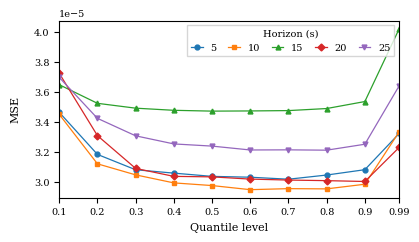

In [98]:
import matplotlib.pyplot as plt

# 1) Drop the 0.999 column (unchanged)
plot_table = mse_table.drop(columns=[0.999])

qs = plot_table.columns.astype(float)
markers = ['o', 's', '^', 'D', 'v']

# ---- SAME publication-style settings as your other figures ----
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "axes.linewidth": 0.8,
    "ps.fonttype": 42,
    "pdf.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(5, 2.3))

# Plot (unchanged semantics; just set linewidth/markersize for readability)
for i, h in enumerate(plot_table.index):
    ax.plot(
        qs,
        plot_table.loc[h].values,
        marker=markers[i % len(markers)],
        markersize=3.5,
        linewidth=0.9,
        label=f"{h}"
    )

# Axis limits and ticks (same intent)
ax.set_xlim(qs.min(), qs.max())
ax.margins(x=0)

ax.set_xticks(qs)
ax.set_xticklabels([str(q) for q in qs])

# Labels (format only)
ax.set_xlabel("Quantile level")
ax.set_ylabel("MSE", labelpad=10)

# Grid (match your other plots)
# ax.grid(True, axis="y", linewidth=0.4, alpha=0.4)
ax.set_axisbelow(True)

# Scientific notation offset font size (if any)
ax.yaxis.get_offset_text().set_fontsize(7)

# Legend (compact, ACM-friendly; keep title and entries same)
n = len(plot_table.index)
ax.legend(
    title="Horizon (s)",
    ncol=n,
    frameon=True,
    fancybox=False,
    loc="upper right",
    fontsize=7,
    title_fontsize=7,
    handlelength=1.2,
    columnspacing=1.2
)

# Prevent label clipping (same fix you use)
fig.subplots_adjust(left=0.22)

# Save EPS for paper
fig.savefig(
    "plots/mse_q_acm.eps",
    format="eps",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.08
)

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


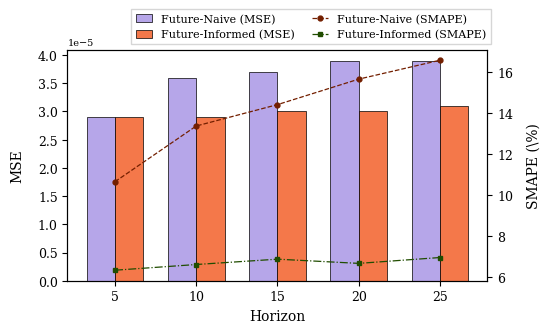

In [113]:
import matplotlib.pyplot as plt
import numpy as np

horizons = np.array([5, 10, 15, 20,25])
mse_unknown   = np.array([ 2.9e-05, 3.6e-05, 3.7e-05, 3.9e-05, 3.9e-05])
mse_tft       = np.array([ 2.9e-05, 2.9e-05, 3.0e-05, 3.0e-05, 3.1e-05])
smape_unknown = np.array([ 10.66, 13.37, 14.41, 15.65,16.57])
smape_tft     = np.array([ 6.352,  6.63,  6.89,  6.685, 6.97 ])

x = np.arange(len(horizons))
width = 0.35

# ---- SAME publication-style settings as your other figures ----
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.linewidth": 0.8,
    "ps.fonttype": 42,
    "pdf.fonttype": 42,
})

fig, ax1 = plt.subplots(figsize=(7, 3))

# --- Left axis: grouped bars for MSE (same data + colors) ---
bars1 = ax1.bar(x - width/2, mse_unknown, width,
                label="Future-Naive (MSE)", color="#B6A6E9",
                edgecolor="black", linewidth=0.5)

bars2 = ax1.bar(x + width/2, mse_tft, width,
                label="Future-Informed (MSE)", color="#F4784A",
                edgecolor="black", linewidth=0.5)

ax1.set_ylabel("MSE", labelpad=10)
ax1.set_xlabel("Horizon")
ax1.set_xticks(x)
ax1.set_xticklabels(horizons)

# keep offset text readable
ax1.yaxis.get_offset_text().set_fontsize(7)

# subtle grid like your other plots
# ax1.grid(True, axis="y", linewidth=0.4, alpha=0.4)
ax1.set_axisbelow(True)

# --- Right axis: line plots for SMAPE (same styles/colors) ---
ax2 = ax1.twinx()
line1, = ax2.plot(x, smape_unknown, marker="o", markersize=3.5,
                  linestyle="--", color="#731F00",
                  linewidth=0.9, label="Future-Naive (SMAPE)")

line2, = ax2.plot(x, smape_tft, marker="s", markersize=3.5,
                  linestyle="-.", color="#204D00",
                  linewidth=0.9, label="Future-Informed (SMAPE)")

ax2.set_ylabel("SMAPE (\%)", labelpad=10)

# --- Combined legend (compact, ACM-friendly) ---
handles = [bars1, bars2, line1, line2]
labels  = [h.get_label() for h in handles]
ax1.legend(
    handles,
    labels,
    ncol=2,                     # 2 columns → 2 rows (since 4 items)
    fontsize=8,
    frameon=True,
    fancybox=False,
    loc="upper center",
    bbox_to_anchor=(0.58, 1.2), # move legend above the plot
    columnspacing=1.5,
    handlelength=1.5
)

# prevent label clipping (same fix you use)
fig.subplots_adjust(left=0.22, right=0.82)

# Save if needed
fig.savefig("plots/future_informed_vs_naive_acm.eps",
            format="eps", dpi=300, bbox_inches="tight", pad_inches=0.08)

plt.show()


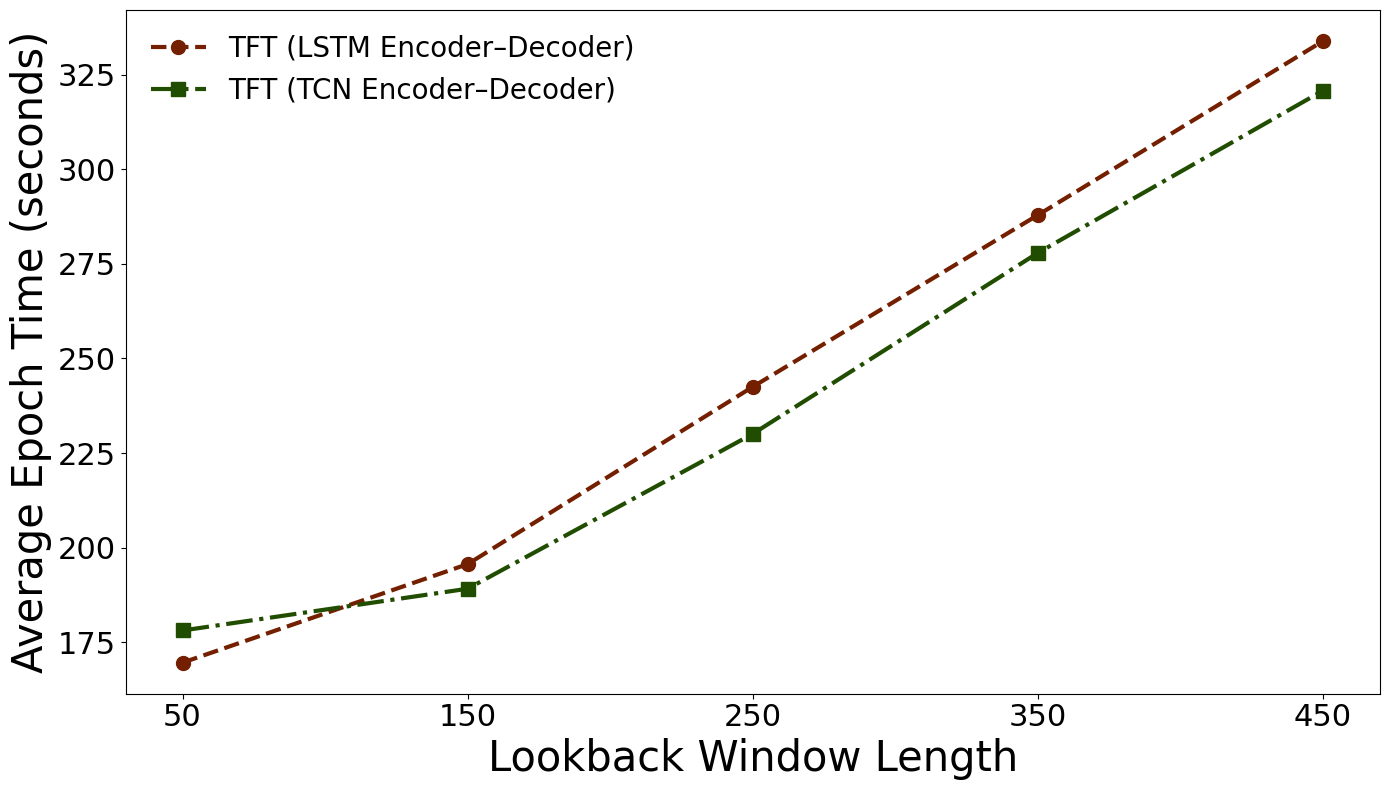

In [3]:
lookbacks = np.array([50, 150, 250, 350, 450])

epoch_time_lstm = np.array([
    169.6,   # L=50
    195.64,   # L=150
    242.51,   # L=250
    287.91,   # L=350
    333.9    # L=450 
])

epoch_time_tcn = np.array([
    178.10,   # L=50
    189.14,   # L=150
    230.07,   # L=250
    277.91,   # L=350
 320.8    # L=450
])

x = np.arange(len(lookbacks))

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 8))

line1, = ax.plot(
    x,
    epoch_time_lstm,
    marker="o",
    linestyle="--",
    linewidth=3,
    markersize=10,
    color="#731F00",
    label="TFT (LSTM Encoder–Decoder)"
)

line2, = ax.plot(
    x,
    epoch_time_tcn,
    marker="s",
    linestyle="-.",
    linewidth=3,
    markersize=10,
    color="#204D00",
    label="TFT (TCN Encoder–Decoder)"
)

# -----------------------------
# Axes formatting
# -----------------------------
ax.set_xlabel("Lookback Window Length", fontsize=30)
ax.set_ylabel("Average Epoch Time (seconds)", fontsize=30)

ax.set_xticks(x)
ax.set_xticklabels(lookbacks, fontsize=22)
ax.tick_params(axis="y", labelsize=22)

# -----------------------------
# Legend
# -----------------------------
ax.legend(
    loc="upper left",
    fontsize=20,
    frameon=False
)

# -----------------------------
# Grid & layout
# -----------------------------
# ax.grid(True, axis="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
